# Deploying Flat-Bug

## Flat-bug setup

In [2]:
# Download the test image
from flat_bug import download_from_repository

image = "test_image.jpg"
download_from_repository(image)

# Import the main model class
from flat_bug.predictor import Predictor

# Optionally import the set_log_level function to control the verbosity of flat-bug module
# from flat_bug import set_log_level
# set_log_level("DEBUG") # default is "INFO"

## Basic Usage

In [3]:
# Load the model
model = Predictor(device="cuda:0", dtype="float16")

# Predict
prediction = model(image)

for k, v in prediction.json_data.items():
    v = str(v)
    if len(v) > 100:
        v = v[:100] + "..."
    print(f"{k}: {v}")

YOLOv8m-seg summary (fused): 263 layers, 24,586,035 parameters, 0 gradients, 98.7 GFLOPs
boxes: [[2620, 1647, 2768, 1821], [915, 1588, 1107, 1804], [1899, 771, 2020, 920], [1768, 578, 1958, 676], ...
contours: [[[2707.33349609375, 2704.0, 2702.0, 2700.0, 2702.0, 2704.0, 2692.0, 2679.33349609375, 2675.33349609...
confs: [0.95458984375, 0.95361328125, 0.94970703125, 0.94482421875, 0.9404296875, 0.93505859375, 0.93457031...
classes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
scales: [1.0, 1.0, 0.8850689939851397, 0.8850689939851397, 0.5900459959900932, 0.8850689939851397, 0.8850689...
areas: [12640.0, 16776.0, 5952.0, 6092.0, 33536.0, 30384.0, 7578.0, 8756.0, 5280.0, 4984.0, 2520.0, 5308.0,...
image_path: test_image.jpg
image_width: 3840
image_height: 2160
mask_width: 3840
mask_height: 2160
identifier: None


## Plot results

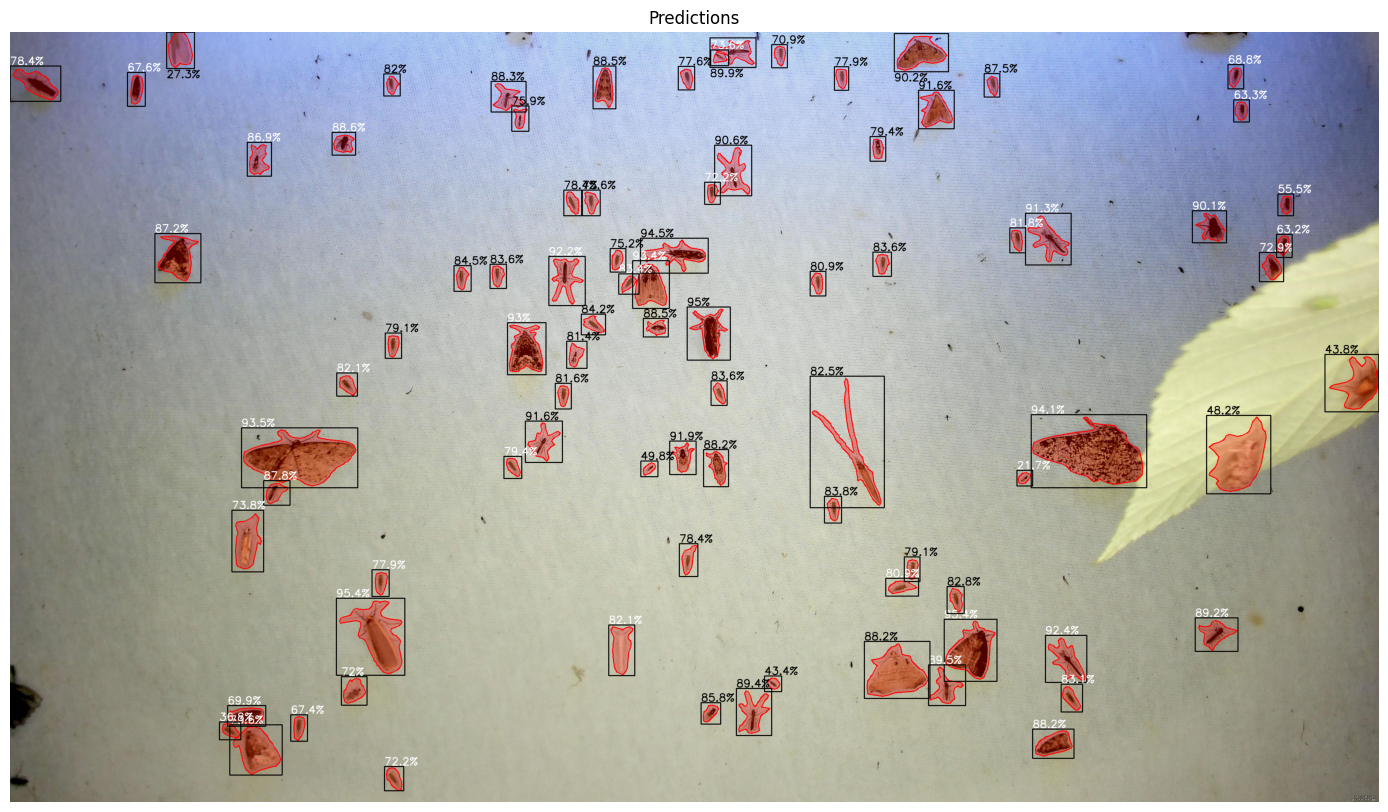

In [4]:
from matplotlib import pyplot as plt

# Plot all the predictions
plt.figure(figsize=(20, 10))
plt.imshow(prediction.plot())
plt.gca().axis("off")
plt.title("Predictions")
plt.show()

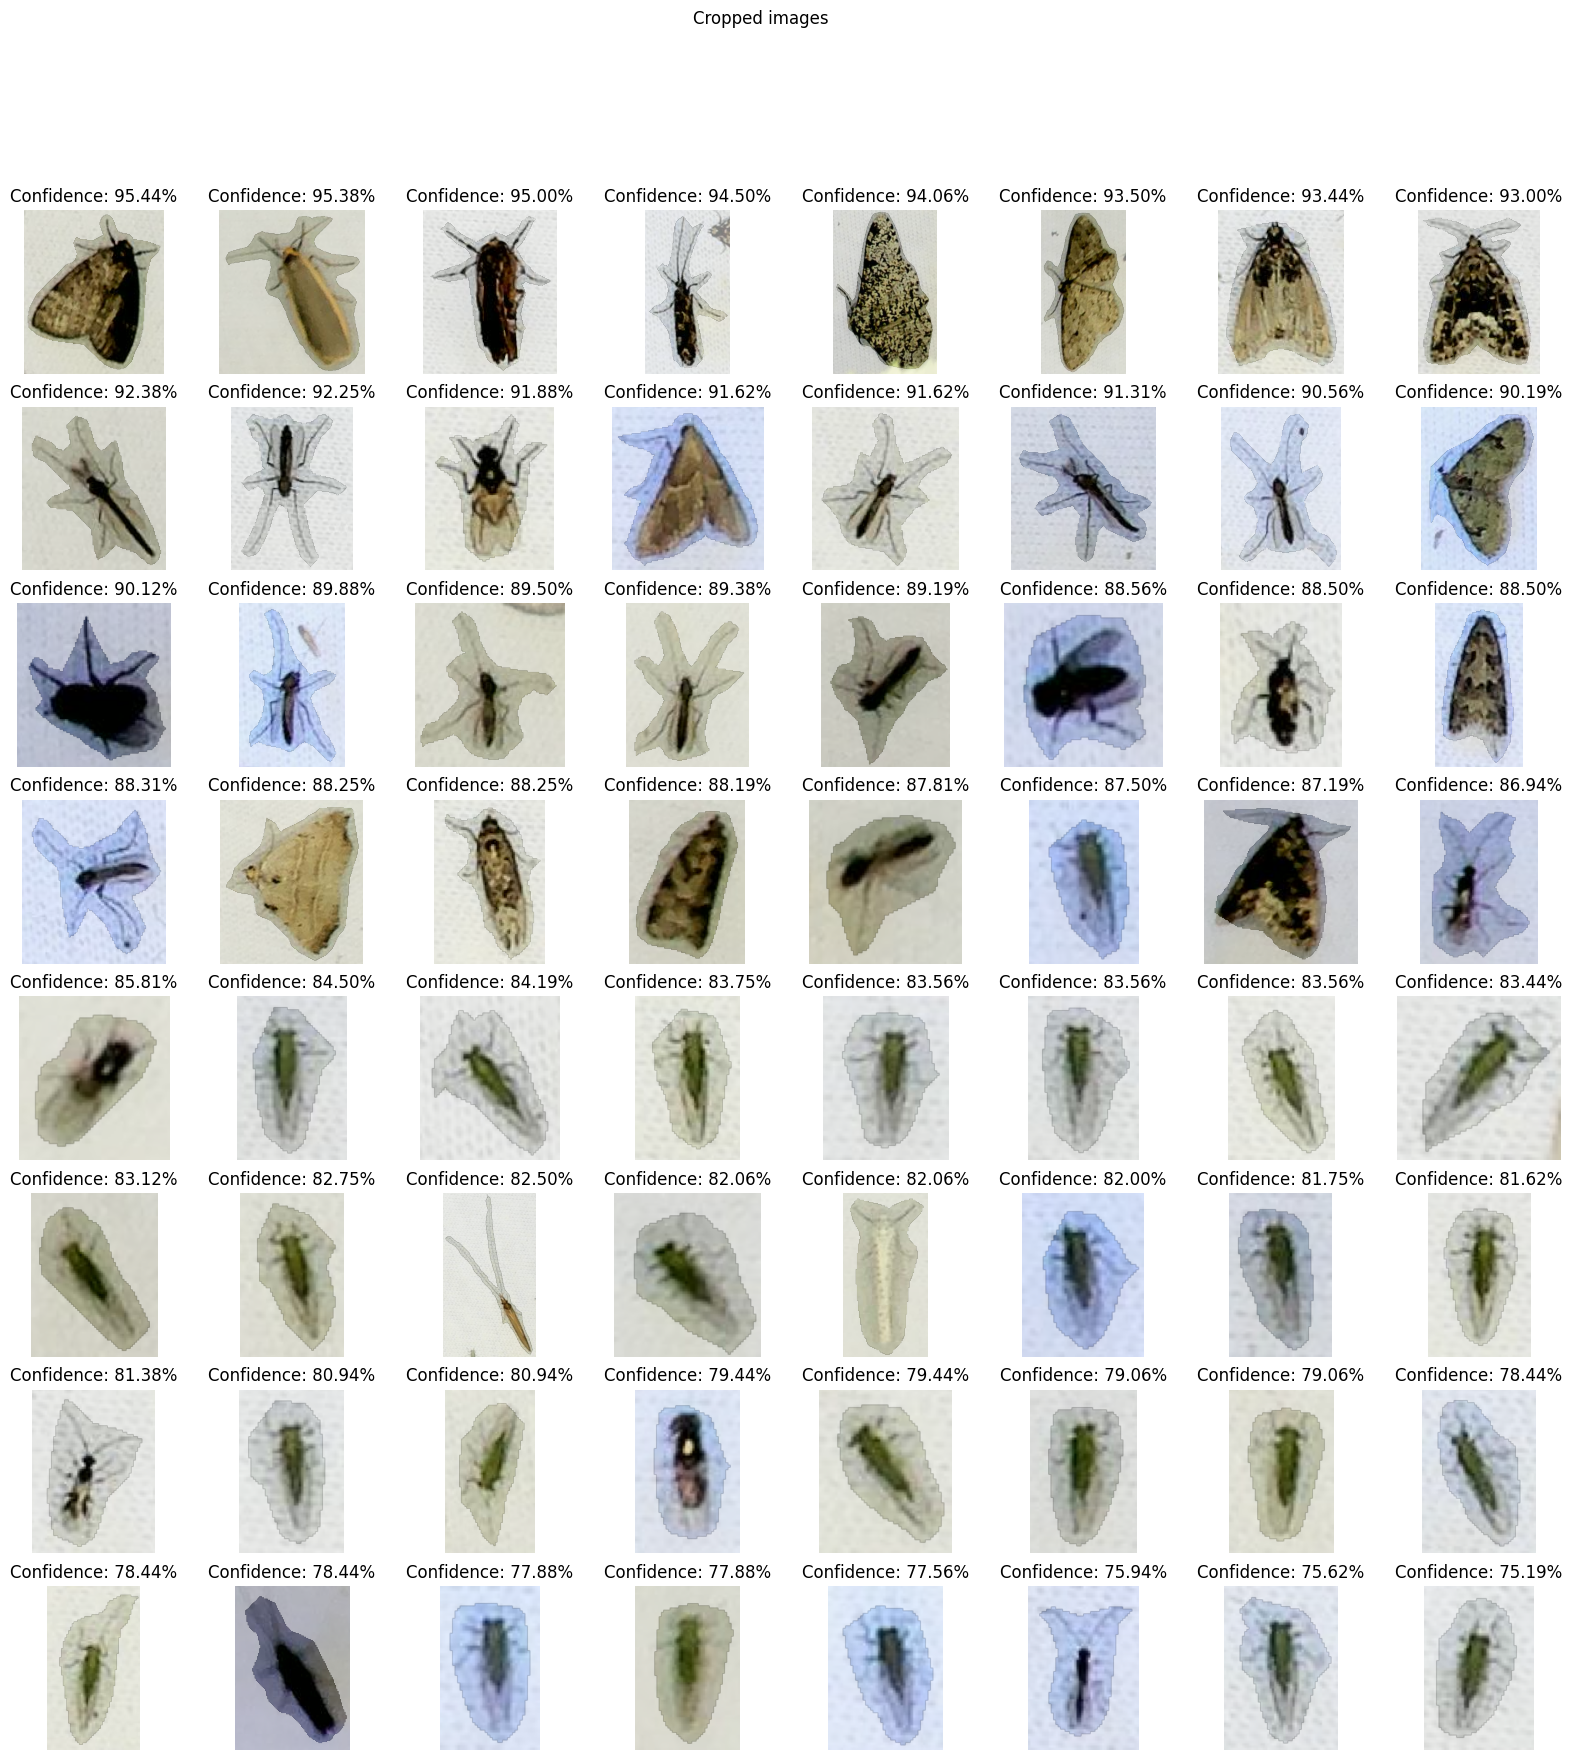

In [5]:
# Plot the cropped images
n_display = min(64, len(prediction))
crops, masks, confidences = prediction.crops[:n_display], prediction.crop_masks[:n_display], prediction.confs[:n_display]

n_crops = len(crops)
ncol = 8
nrow = n_crops // ncol
if n_crops % ncol:
    nrow += 1

fig, axs = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2.5 * nrow))
axs = axs.flatten() if n_crops > 1 else [axs]
for ax, crop, mask, conf in zip(axs, crops, masks, confidences):
    crop = crop.permute(1, 2, 0).cpu()
    mask = 1 - mask.squeeze(0).cpu().float()
    w, h = mask.shape
    if w < h:
        mask = mask.transpose(1, 0)
        crop = crop.transpose(1, 0)
    ax.imshow(crop)
    ax.imshow(mask, cmap="gray", vmin=0, vmax=1, alpha=mask * 0.5) 
    ax.set_title(f"Confidence: {conf * 100:.2f}%")
    ax.axis("off")
plt.suptitle("Cropped images")
plt.show()

## Advanced Usage

## Hyperparameters

Timings using the default arguments


2025-03-28 19:18:10 - flat_bug - INFO - Prediction time: 0.758s/86.7% (overhead: 0.0%) | Fetch 0.8% | Forward 77.6% | Postprocess 21.6% | Tiles 18
2025-03-28 19:18:11 - flat_bug - INFO - Prediction time: 0.465s/80.2% (overhead: 0.0%) | Fetch 0.1% | Forward 64.2% | Postprocess 35.7% | Tiles 15
2025-03-28 19:18:11 - flat_bug - INFO - Prediction time: 0.208s/75.6% (overhead: 0.1%) | Fetch 0.1% | Forward 53.5% | Postprocess 46.4% | Tiles 6
2025-03-28 19:18:11 - flat_bug - INFO - Prediction time: 0.076s/74.5% (overhead: 0.1%) | Fetch 0.1% | Forward 47.3% | Postprocess 52.6% | Tiles 2
2025-03-28 19:18:11 - flat_bug - INFO - Prediction time: 0.035s/81.0% (overhead: 0.4%) | Fetch 0.1% | Forward 59.2% | Postprocess 40.7% | Tiles 1
2025-03-28 19:18:11 - flat_bug - INFO - Total detection time: 1.874s (56.3% forward)
2025-03-28 19:18:12 - flat_bug - INFO - Combining 5 predictions into a single TensorPredictions object took 0.363 s | Duplication removal: 0.241 s | Mask combination: 0.076 s
2025-03-

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)


2025-03-28 19:18:14 - flat_bug - INFO - Prediction time: 0.279s/81.9% (overhead: 0.0%) | Fetch 0.1% | Forward 69.2% | Postprocess 30.7% | Tiles 6
2025-03-28 19:18:14 - flat_bug - INFO - Total detection time: 0.341s (56.6% forward)
2025-03-28 19:18:14 - flat_bug - INFO - Combining 1 predictions into a single TensorPredictions object took 0.067 s | Duplication removal: 0.041 s | Mask combination: 0.016 s
2025-03-28 19:18:14 - flat_bug - INFO - Initializing TensorPredictions took 0.068 s
2025-03-28 19:18:14 - flat_bug - INFO - Offsetting, scaling and padding took 0.004 s
2025-03-28 19:18:14 - flat_bug - INFO - Non-maximum suppression took 0.088s for removing 65 elements of 107 elements
2025-03-28 19:18:14 - flat_bug - INFO - Total pyramid time: 0.537s (63.4% detection | 35.9% forward)


Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)


2025-03-28 19:18:14 - flat_bug - INFO - Prediction time: 0.204s/77.4% (overhead: 0.1%) | Fetch 0.1% | Forward 54.8% | Postprocess 45.1% | Tiles 6
2025-03-28 19:18:15 - flat_bug - INFO - Prediction time: 0.074s/75.0% (overhead: 0.2%) | Fetch 0.1% | Forward 46.2% | Postprocess 53.7% | Tiles 2
2025-03-28 19:18:15 - flat_bug - INFO - Prediction time: 0.026s/79.9% (overhead: 0.6%) | Fetch 0.5% | Forward 73.3% | Postprocess 26.2% | Tiles 1
2025-03-28 19:18:15 - flat_bug - INFO - Total detection time: 0.394s (41.7% forward)
2025-03-28 19:18:15 - flat_bug - INFO - Combining 3 predictions into a single TensorPredictions object took 0.134 s | Duplication removal: 0.077 s | Mask combination: 0.038 s
2025-03-28 19:18:15 - flat_bug - INFO - Initializing TensorPredictions took 0.135 s
2025-03-28 19:18:15 - flat_bug - INFO - Offsetting, scaling and padding took 0.011 s
2025-03-28 19:18:15 - flat_bug - INFO - Non-maximum suppression took 0.202s for removing 121 elements of 163 elements
2025-03-28 19:1

Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)


2025-03-28 19:18:16 - flat_bug - INFO - Non-maximum suppression took 0.251s for removing 11 elements of 25 elements
2025-03-28 19:18:16 - flat_bug - INFO - Total pyramid time: 0.370s (18.1% detection | 9.43% forward)


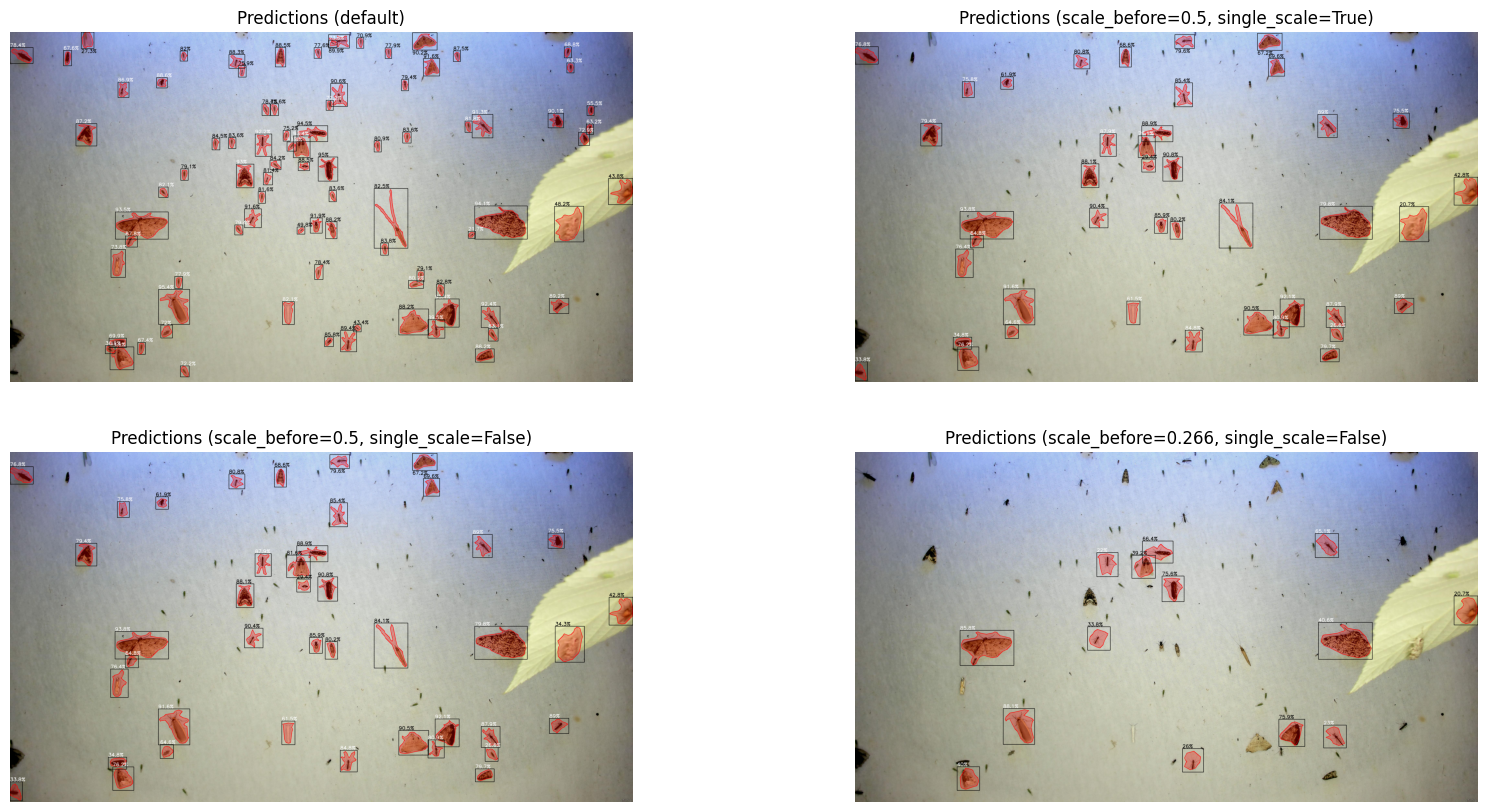

In [6]:
# We can set the model hyperparameters after loading the model with the set_hyperparameters method
model.set_hyperparameters(
    TIME = True,
    # IOU_THRESHOLD, etc. see the documentation for more options
)

# Here I will demonstrate how to use the pyramid_predictions method with custom arguments and compare the timings and results
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()

# Predict with defaults
print("Timings using the default arguments")
axs[0].imshow(model.pyramid_predictions(image).plot()) # Default arguments (scale_before=1.0, single_scale=False)
axs[0].axis("off")
axs[0].set_title("Predictions (default)")

# Predict with custom arguments
print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=True)")
axs[1].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=True).plot()) # Scale the image down by 50% and only predict at the native level
axs[1].axis("off")
axs[1].set_title("Predictions (scale_before=0.5, single_scale=True)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.5, single_scale=False)")
axs[2].imshow(model.pyramid_predictions(image, scale_before=0.5, single_scale=False).plot()) # Scale the image down by 50% and tile from there
axs[2].axis("off")
axs[2].set_title("Predictions (scale_before=0.5, single_scale=False)")

print("Timings after manually overriding the pyramid_predictions arguments (scale_before=0.266, single_scale=False)") # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].imshow(model.pyramid_predictions(image, scale_before=0.266, single_scale=False).plot()) # Scale the image down such that the largest dimension is smaller than the tile size (1024)
axs[3].axis("off")
axs[3].set_title("Predictions (scale_before=0.266, single_scale=False)")

# Show plot
plt.show()